# CS579: Lecture 10  

**Sentiment Analysis**

*[Dr. Aron Culotta](http://cs.iit.edu/~culotta)*  
*[Illinois Institute of Technology](http://iit.edu)*

*Warning: Live Twitter data is used below, some of which may be offensive.*

**sen·ti·ment**

1. a view of or attitude toward a situation or event; an opinion.
2. a feeling or emotion.


**sen·ti·ment &nbsp; a·nal·y·sis ** 

1. classification of documents/messages by sentiment

# Examples

![tmnt.png](tmnt.png)

![ufo](ufo.png)

![ufo-review](ufo-review.png)

![mcds](mcds.png)

![rauner](rauner.png)
![quinn](quinn.png)

## Why is this hard?


# Two Approaches

- Lexicons (word lists)

- Machine learning

# Lexicons

- List of terms with positive/negative/neutral sentiment

- E.g., AFINN: http://neuro.imm.dtu.dk/wiki/AFINN


In [15]:
# Download the AFINN lexicon, unzip, and read the latest word list in AFINN-111.txt
from StringIO import StringIO
from zipfile import ZipFile
from urllib import urlopen

url = urlopen('http://www2.compute.dtu.dk/~faan/data/AFINN.zip')
zipfile = ZipFile(StringIO(url.read()))
afinn_file = zipfile.open('AFINN/AFINN-111.txt')

afinn = dict()

for line in afinn_file:
    parts = line.strip().split()
    if len(parts) == 2:
        afinn[parts[0]] = int(parts[1])

print 'read', len(afinn), 'AFINN terms.\nE.g.:', afinn.items()[:10]

read 2462 AFINN terms.
E.g.: [('limited', -1), ('suicidal', -2), ('pardon', 2), ('desirable', 2), ('protest', -2), ('lurking', -1), ('controversial', -2), ('hating', -3), ('ridiculous', -3), ('hate', -3)]


In [18]:
len(afinn)

2462

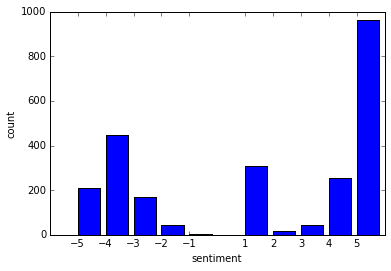

In [19]:
# What is the distribution of scores?
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

counts = Counter(afinn.values())
vals = sorted(counts.keys())

plt.bar(vals, counts.values())
plt.xticks(vals)
plt.xlabel('sentiment')
plt.ylabel('count')
plt.show()

In [21]:
# How do we score a document?
def afinn_sentiment(terms, afinn):
    total = 0.
    for t in terms:
        if t in afinn:
            print '\t%s=%d' % (t, afinn[t])
            total += afinn[t]
    return total
    
doc = "i don't know if this is a scam or if mine was broken".split()
print 'AFINN:\n', afinn_sentiment(doc, afinn)

AFINN:
	scam=-2
	broken=-1
-3.0


In [22]:
# What if mixed sentiment?
doc = "it has a hokey plot that is both to good and bad".split()
print 'AFINN:\n', afinn_sentiment(doc, afinn)

AFINN:
	good=3
	bad=-3
0.0


In [23]:
# Distinguish neutral from pos/neg.
# Return two scores per document.
def afinn_sentiment2(terms, afinn, verbose=False):
    pos = 0
    neg = 0
    for t in terms:
        if t in afinn:
            if verbose:
                print '\t%s=%d' % (t, afinn[t])
            if afinn[t] > 0:
                pos += afinn[t]
            else:
                neg += -1 * afinn[t]
    return pos, neg

doc = "it has a hokey plot that is both to good and bad".split()
print 'AFINN:\n', afinn_sentiment2(doc, afinn, verbose=True)

AFINN:
	good=3
	bad=-3
(3, 3)


In [24]:
import ConfigParser
from TwitterAPI import TwitterAPI

# Get some tweets about McDonald's

def get_twitter(config_file):
    """ Read the config_file and construct an instance of TwitterAPI.
    Args:
      config_file ... A config file in ConfigParser format with Twitter credentials
    Returns:
      An instance of TwitterAPI.
    """
    config = ConfigParser.ConfigParser()
    config.read(config_file)
    twitter = TwitterAPI(
                   config.get('twitter', 'consumer_key'),
                   config.get('twitter', 'consumer_secret'),
                   config.get('twitter', 'access_token'),
                   config.get('twitter', 'access_token_secret'))
    return twitter

twitter = get_twitter('twitter.cfg')
tweets = []
for r in twitter.request('search/tweets', {'q': 'mcdonalds', 'count': 100}):
    tweets.append(r)

In [25]:
print 'read %d mcdonalds tweets' % len(tweets)

read 100 mcdonalds tweets


In [29]:
# Tokenize tweets
import re

def tokenize(text):
    return re.sub('\W+', ' ', text.lower()).split()

tokens = [tokenize(t['text']) for t in tweets]
print 'tokenized, e.g., \n%s\nto\n%s' % (tweets[50]['text'], tokens[50])   

tokenized, e.g., 
RT @KamikazeCapilar: No entiendo a la gente que va a Mcdonalds a comer ensalada
to
[u'rt', u'kamikazecapilar', u'no', u'entiendo', u'a', u'la', u'gente', u'que', u'va', u'a', u'mcdonalds', u'a', u'comer', u'ensalada']


In [30]:
positives = []
negatives = []
for tweet in tokens:
    pos, neg = afinn_sentiment2(tweet, afinn)
    if pos > neg:
        positives.append((' '.join(tweet), pos, neg))
    elif neg > pos:
        negatives.append((' '.join(tweet), pos, neg))

In [31]:
# Print top positives:
for tweet, pos, neg in sorted(positives, key=lambda x: x[1], reverse=True):
    print pos, neg, tweet

7 0 rt guncalls chickfila hi welcome to chickfila it s a beautiful day it is 72 and you are blessed abundantly how may i help you mcdonal
6 0 khack best birthday present ever let s celebrate together on 10 6 kyle
4 0 that mcdonalds was just amazing
4 1 no jen i m not coming back to mcdonalds lmao
4 0 kinda want mcdonalds fries lol
3 0 rt pledgeszn 10 free chicken nugs from mcdonalds since the texans had 100 rush yards rt to help sorority girls everywhere
3 1 rt robtm_ two years ago i was in mcdonalds with no right direction today i own a successful business anything is possible http t c
3 0 i ve had them but i ve gotta say i love mcdonalds a little more https t co rgznwzvfgt
3 0 rt bobbybatson06 hanging w my buddy ronaldmcdonald 90minutesheaven mcdonalds love fries fries mcdonalds 90minutesinheaven http t
3 0 pharrell teste le nouveau grand premium de mcdonald s mcdonald s vient de lancer un nouveau sandwich c est http t co w7p2jpmprm
3 1 rt robtm_ two years ago i was in mcdonalds with

In [32]:
print afinn['free']

1


In [33]:
# Print top negatives:
for tweet, pos, neg in sorted(negatives, key=lambda x: x[2], reverse=True):
    print pos, neg, tweet

0 8 rt roach_nigga when the fuck ass mcdonalds worker nigga only give you 1 sauce for 20 mcnuggets http t co i0ognskfcm
0 6 rt hoeverses haters gonna hate hoes gonna hoe and mcdonalds workers gonna give attitude when u ask for extra sauce
3 4 my trust so fucked up ion even like to give mcdonalds my money before they give me my food
1 4 hey mcdonalds no matter what you say in your uk commercials you re still crap
0 4 rt mryungnsonneek that burger put me in a coma fuck you mcdonalds
2 3 i liked a youtube video from alltime10s http t co 0dyfryymbm 10 disgusting facts about mcdonalds
1 2 rt extrasexual mcdonalds in japan is cherry blossom themed i m crying it s so pretty http t co o2t6vosrqz
0 2 new mcdonald s organic burger half the taste twice the shame http t co 6n2ybilh9i via esquire
1 2 rt extrasexual mcdonalds in japan is cherry blossom themed i m crying it s so pretty http t co o2t6vosrqz
0 2 if i ever see this again i will be filing a lawsuit mcdonalds http t co q0fw35zv9i
0 1 aler

# Sentiment Trends?
![politico](politico.png)

What can go wrong?

In [34]:
# Which words contribute most to sentiment?
all_counts = Counter()
for tweet in tokens:
    all_counts.update(tweet)
sorted_tokens = sorted(all_counts.items(), key=lambda x:x[1], reverse=True)
i = 0
for token, count in sorted_tokens:
    if token in afinn:
        print '%s count=%d sentiment=%d' % (token, count, afinn[token])
        i += 1
        if i > 10:
            break

no count=11 sentiment=-1
successful count=7 sentiment=3
hard count=4 sentiment=-1
free count=4 sentiment=1
like count=4 sentiment=2
lol count=3 sentiment=3
pretty count=3 sentiment=1
love count=2 sentiment=3
fuck count=2 sentiment=-4
help count=2 sentiment=2
please count=2 sentiment=1


# Part of speech?

> *I hate McDonlads.*  
> *Hate speech is wrong.*

> *Rauner is lying.*  
> *Lying in bed with the flu.*

Noun/verb/adjective form of term may have different sentiment.

# WordNet

- A database of words and their relations
- http://wordnet.princeton.edu/
- Statistics: http://wordnet.princeton.edu/wordnet/man/wnstats.7WN.html

# WordNet

- **Synset:**
  - A list of synonyms
  - E.g. [dog](http://wordnetweb.princeton.edu/perl/webwn?s=dog&sub=Search+WordNet&o2=&o0=1&o8=1&o1=1&o7=&o5=&o9=&o6=&o3=&o4=&h=11000000000000000000001000000000)
- **Hypernym:**
  - Y is a Hypernym of X if every X is a kind of Y
    - **canine** is a hypernym of **dog**

# SentiWordNet

http://sentiwordnet.isti.cnr.it/

In [35]:
from nltk.corpus import sentiwordnet as swn
# Depends on nltk (pip install nltk)
# See http://www.nltk.org/data.html
happy = swn.senti_synsets('happy', 'a')[0]
print happy

<happy.a.01: PosScore=0.875 NegScore=0.0>


In [39]:
sad = swn.senti_synsets('hate', 'n')[0]
print sad

<hate.n.01: PosScore=0.125 NegScore=0.375>
